In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, os, string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Lambda, Dense
import tensorflow.keras.backend as K

Preprocessing dataset

In [ ]:
def read_data(pathdata):
    traindata = []
    sents = open(pathdata, 'r', encoding='utf-8').readlines()
    for sent in sents:
        traindata.append(sent.split())
    return traindata

train_data = read_data("datatrain (1).txt")
print(train_data[:10])  # Print first 10 lines of training data as example


[['danh_sách', 'tác_phẩm', 'doraemon'], ['doraemon', 'nguyên_tác', 'là', 'xê', 'ri', 'anime', 'và', 'manga', 'được', 'sáng_tác', 'bởi', 'fujiko_f'], ['bắt_đầu_từ', 'những', 'chương', 'truyện', 'nhỏ', 'đăng', 'trên', 'tạp_chí', 'tháng', 'corocoro', 'comic', 'sau', 'đó', 'shogakukan', 'tập_hợp', 'lại', 'phát_hành', 'theo', 'cuốn', 'từ', 'tập', '1', 'đến', 'tập', '45'], ['sau', 'đó', 'chuyển_thể', 'thành', 'anime', 'theo', 'ba', 'giai_đoạn', 'phim', 'hoạt_hình', '1973', '1979', '2005', 'và', '2005'], ['năm', '2014', 'viz_media', 'mua', 'bản_quyền', 'mỹ_hóa', 'các', 'yếu_tố', 'trong', 'phim', 'như', 'tên', 'nhân_vật', 'địa_điểm'], ['và', 'phát_sóng', 'trên', 'disney', 'xd', 'kể', 'từ', '7', 'tháng', '7'], ['xê', 'ri', 'cũng', 'được', 'chuyển_thể', 'thành', 'nhiều', 'tác_phẩm', 'khác', 'nhau', 'như', 'doraemon_plus', 'truyện_ngắn', 'truyện_dài', 'phim', 'điện_ảnh', 'trò_chơi', 'điện_tử', 'nhạc_kịch', 'băng_đĩa'], ['dưới', 'đây', 'là', 'danh_sách', 'các', 'tác_phẩm', 'về', 'doraemon', 'được'

# 1. Building a vector space model for Vietnamese

### One-hot Encoding

In [ ]:
train_data_str = [' '.join(sent) for sent in train_data[:4]]

vectorizer = CountVectorizer(binary=True)

one_hot_encoded = vectorizer.fit_transform(train_data_str)

one_hot_encoded_array = one_hot_encoded.toarray()

for i in range(0, 3):
    print("Câu gốc: ", train_data_str[i])
    print("Minh Họa One Hot Encoding: ", one_hot_encoded_array[i])
    print("\n")

Câu gốc:  danh_sách tác_phẩm doraemon
Minh Họa One Hot Encoding:  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0]


Câu gốc:  doraemon nguyên_tác là xê ri anime và manga được sáng_tác bởi fujiko_f
Minh Họa One Hot Encoding:  [0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 1 0]


Câu gốc:  bắt_đầu_từ những chương truyện nhỏ đăng trên tạp_chí tháng corocoro comic sau đó shogakukan tập_hợp lại phát_hành theo cuốn từ tập 1 đến tập 45
Minh Họa One Hot Encoding:  [0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1
 1 1 1 0 0 1 1 0 1]




### TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_encoded = tfidf_vectorizer.fit_transform(train_data_str)

tfidf_encoded_array = tfidf_encoded.toarray()

for i in range(0, 3):
    print("Câu gốc: ", train_data_str[i])
    print("Minh Họa TF-IDF Encoding: ", tfidf_encoded_array[i])
    print("\n")

Câu gốc:  danh_sách tác_phẩm doraemon
Minh Họa TF-IDF Encoding:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.61761437 0.48693426 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.61761437
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


Câu gốc:  doraemon nguyên_tác là xê ri anime và manga được sáng_tác bởi fujiko_f
Minh Họa TF-IDF Encoding:  [0.         0.         0.         0.         0.23918972 0.
 0.         0.30338183 0.         0.         0.         0.
 0.         0.         0.23918972 0.30338183 0.         0.
 0.30338183 0.         0.30338183 0.30338183 0.         0.
 0.         0.         0.30338183 0.         0.         0.30338183
 0.         0.         0.         0.         0.        

### Windows based cooccurence matrix

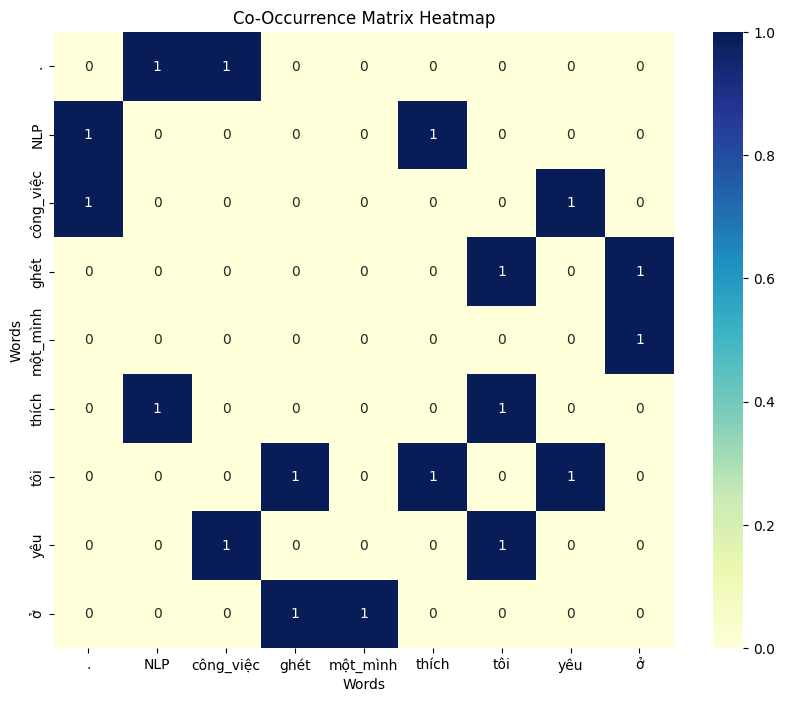

In [ ]:
corpus = ["tôi yêu công_việc .",
          "tôi thích NLP .",
          "tôi ghét ở một_mình"]

words = []
for sentence in corpus:
    words.extend(sentence.split())

words = list(set(words))
words.sort()

X = np.zeros((len(words), len(words)))

for sentence in corpus:
    tokens = sentence.split()
    for i, token in enumerate(tokens):
        if i == 0:
            X[words.index(token), words.index(tokens[i + 1])] += 1
        elif i == len(tokens) - 1:
            X[words.index(token), words.index(tokens[i - 1])] += 1
        else:
            X[words.index(token), words.index(tokens[i + 1])] += 1
            X[words.index(token), words.index(tokens[i - 1])] += 1

plt.figure(figsize=(10, 8))
sns.heatmap(X, xticklabels=words, yticklabels=words, cmap="YlGnBu", annot=True, fmt="g")

plt.title("Co-Occurrence Matrix Heatmap")
plt.xlabel("Words")
plt.ylabel("Words")
plt.show()


### Singular Value Decomposition (SVD).

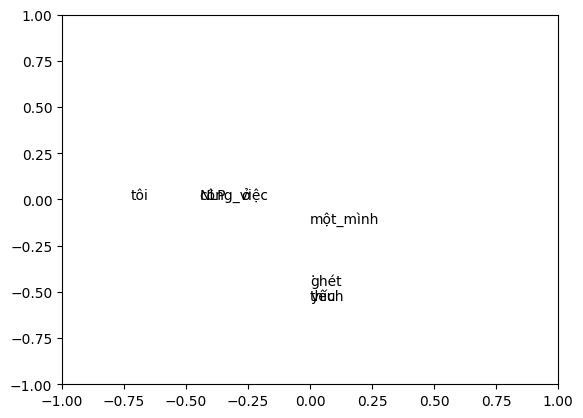

In [ ]:
la = np.linalg
U, s, Vh = la.svd(X, full_matrices=False)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

for i in range(len(words)):
    plt.text(U[i, 0], U[i, 1], words[i])

plt.show()

In [ ]:
train_data = [' '.join(sent) for sent in train_data]

### Word2Vec

In [ ]:
import gensim.models.keyedvectors as word2vec
from sklearn.decomposition import PCA
from gensim.models import Word2Vec

In [ ]:
model = Word2Vec(train_data, vector_size=150, window=10, min_count=2, workers=4, sg=0)
model.wv.save("word2vec_skipgram.model")

In [ ]:
model = word2vec.KeyedVectors.load('word2vec_skipgram.model')

for word in model.most_similar(u"biển"):
    print(word[:3])

('cạn', 0.6690890789031982)
('bãi', 0.6520583033561707)
('bờ', 0.6488260626792908)
('hồ', 0.6337935328483582)
('vùng_biển', 0.6336227059364319)
('vịnh', 0.625466525554657)
('vùng_ven', 0.6231028437614441)
('đại_tây_dương', 0.6185645461082458)
('vũng', 0.6148403286933899)
('thềm', 0.6138408780097961)


### Visualization

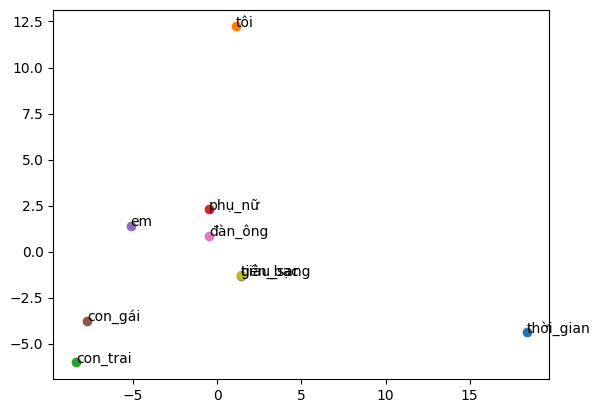

In [ ]:
model = word2vec.KeyedVectors.load('word2vec_skipgram.model')

pathfile = 'words.txt'
with open(pathfile, 'r', encoding='utf-8') as f:
    words = f.readlines()
    words = [word.strip() for word in words]

words_np = []
words_label = []

for word in model.key_to_index.keys():
    if word in words:
        words_np.append(model[word])
        words_label.append(word)

pca = PCA(n_components=2)
pca.fit(words_np)
reduced = pca.transform(words_np)


def visualize():
    fig, ax = plt.subplots()

    for index, vec in enumerate(reduced):
        x, y = vec[0], vec[1]

        ax.scatter(x, y)
        ax.annotate(words_label[index], xy=(x, y))

    plt.show()
    return

visualize()